In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

# 1 Building an End-to-End Image Classifier with CNNs.

## 1.1 Data Understanding and Visualizations.

Verify Dataset:

In [3]:
train_dir = '/content/drive/MyDrive/6CS012 AI & ML/FruitinAmazon/FruitinAmazon/train'
test_dir = '/content/drive/MyDrive/6CS012 AI & ML/FruitinAmazon/FruitinAmazon/test'

In [4]:
import os
class_names = sorted(os.listdir(train_dir))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


Check for Corrupted Images:

In [5]:

corrupted_images = []  # List to store corrupted image paths

# Loop through each class folder and check for corrupted images
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # Ensure it's a valid directory
        images = os.listdir(class_path)
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify image integrity
            except (IOError, UnidentifiedImageError):
                corrupted_images.append(img_path)

# Print results
if corrupted_images:
    print("\nCorrupted Images Found:")
    for img in corrupted_images:
        print(img)
else:
    print("\nNo corrupted images found.")



No corrupted images found.


Count class Balance:

In [6]:
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(images)

print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
    print(f"{class_name:<25}{count:>15}")
print("=" * 45)



Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


Select Random Images for Visualization:

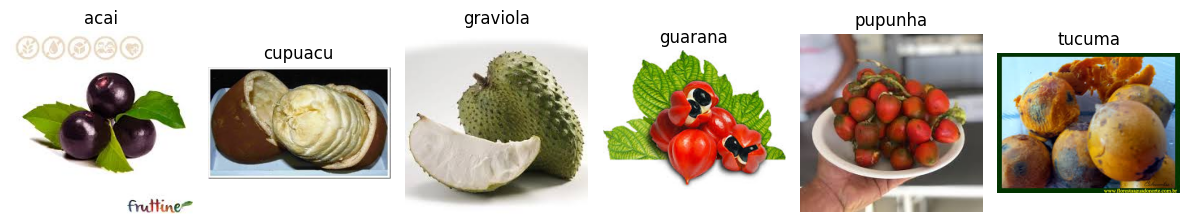

In [7]:


selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            selected_img = os.path.join(class_path, random.choice(images))
            selected_images.append(selected_img)
            selected_labels.append(class_name)

num_classes = len(selected_images)
fig, axes = plt.subplots(1,num_classes, figsize=(12,6))

if num_classes == 1:
    axes = [axes]

for ax, img_path, label in zip(axes, selected_images, selected_labels):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [8]:
# Define image size and batch size
img_height = 224
img_width = 224
batch_size = 64


# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    label_mode='categorical',
    seed=123
)

# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

# Verify class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")




Found 90 files belonging to 6 classes.
Found 30 files belonging to 6 classes.
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Number of classes: 6


In [9]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [10]:

from tensorflow.keras.layers import LeakyReLU

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    for filters in [32, 64, 128, 256]:
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.15)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

model = make_model(input_shape=(224, 224, 3), num_classes=num_classes)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,0

 Total params: 491,334 (1.87 MB)

 Trainable params: 489,606 (1.87 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [11]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
# Callbacks
checkpoint = ModelCheckpoint('best_model_task1.h5', monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train
history = model.fit(
    train_ds,
    epochs=250,
    batch_size = batch_size,
    validation_data=test_ds,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1970 - loss: 2.3344  

2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 24s/step - accuracy: 0.2054 - loss: 2.3079 - val_accuracy: 0.1667 - val_loss: 1.7810
Epoch 2/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.3441 - loss: 1.7982

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 421ms/step - accuracy: 0.3442 - loss: 1.7951 - val_accuracy: 0.3000 - val_loss: 1.7700
Epoch 3/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.4569 - loss: 1.3540 - val_accuracy: 0.2000 - val_loss: 1.7647
Epoch 4/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step - accuracy: 0.4948 - loss: 1.3628 - val_accuracy: 0.2667 - val_loss: 1.7598
Epoch 5/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step - accuracy: 0.5422 - loss: 1.4194 - val_accuracy: 0.3000 - val_loss: 1.7499
Epoch 6/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.4276 - loss: 1.4114

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step - accuracy: 0.4295 - loss: 1.3941 - val_accuracy: 0.3667 - val_loss: 1.7392
Epoch 7/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 492ms/step - accuracy: 0.5497 - loss: 1.2998 - val_accuracy: 0.3333 - val_loss: 1.7310
Epoch 8/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - accuracy: 0.6031 - loss: 1.1008 - val_accuracy: 0.2000 - val_loss: 1.7276
Epoch 9/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step - accuracy: 0.5601 - loss: 1.2004 - val_accuracy: 0.2000 - val_loss: 1.7299
Epoch 10/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - accuracy: 0.5653 - loss: 1.1854 - val_accuracy: 0.1667 - val_loss: 1.7369
Epoch 11/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - accuracy: 0.5927 - loss: 1.1038 - val_accuracy: 0.1667 - val_loss: 1.7461
Epoch 12/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.5979 - loss: 0.9379 - val_accuracy: 0.1667 - val_loss: 1.7609
Epoch 13/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - accuracy: 0.6610 - loss: 0.9799 - val_accuracy: 0.1667 - val_loss:

In [13]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.2000 - loss: 1.7276
Test accuracy: 0.2000
Test loss: 1.7276


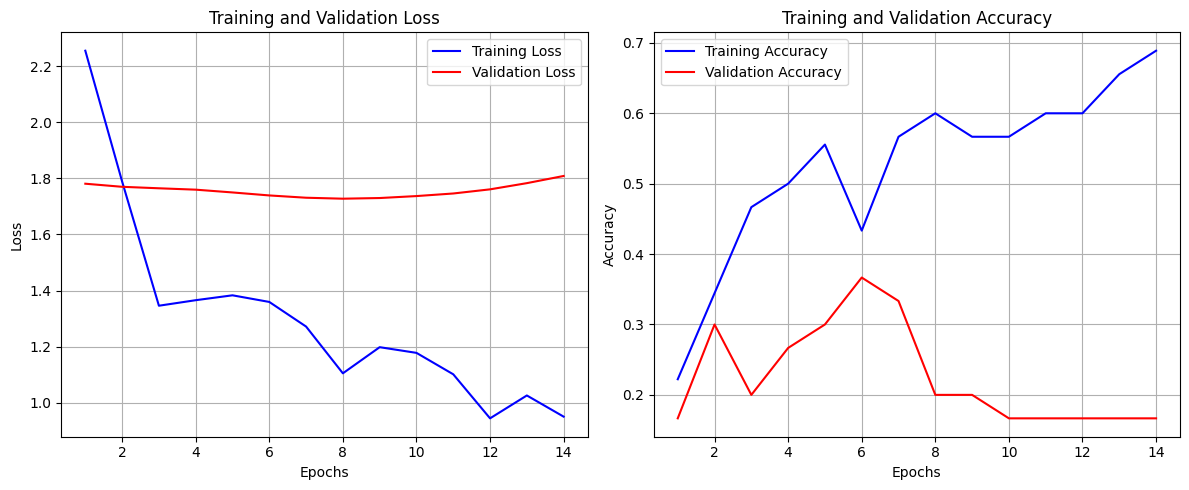

In [14]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [15]:
model.save('SachinGyawali_w6_task1.h5')
print("Model saved as 'SachinGyawali_w6_task1.h5'")

Model saved as 'SachinGyawali_w6_task1.h5'


In [16]:

loaded_model = tf.keras.models.load_model('SachinGyawali_w6_task1.h5')
loaded_test_loss, loaded_test_acc = loaded_model.evaluate(test_ds)
print(f"Loaded model test accuracy: {loaded_test_acc:.4f}")
print(f"Loaded model test loss: {loaded_test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step - accuracy: 0.2000 - loss: 1.7276
Loaded model test accuracy: 0.2000
Loaded model test loss: 1.7276


In [17]:
loaded_model = keras.models.load_model('SachinGyawali_w6_task1.h5')
print("Model loaded for predictions")

# Collect all test images and labels
all_images = []
all_labels = []
for images, labels in test_ds:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

# Concatenate batches into single arrays
test_images = np.concatenate(all_images, axis=0)  # Shape: (30, 128, 128, 3)
test_labels_onehot = np.concatenate(all_labels, axis=0)  # Shape: (30, 6)

# Make predictions
predictions = loaded_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_onehot, axis=1)


print(f"Class names: {class_names}")

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", report)

Model loaded for predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Classification Report:
               precision    recall  f1-score   support

        acai       0.00      0.00      0.00         5
     cupuacu       0.17      1.00      0.29         5
    graviola       0.00      0.00      0.00         5
     guarana       0.00      0.00      0.00         5
     pupunha       1.00      0.20      0.33         5
      tucuma       0.00      0.00      0.00         5

    accuracy                           0.20        30
   macro avg       0.20      0.20      0.10        30
weighted avg       0.20      0.20      0.10        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model_vgg = keras.Model(inputs=base_model.input, outputs=outputs)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [19]:
model_vgg.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history_vgg = model_vgg.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,
    callbacks=[ModelCheckpoint('best_model_task2.h5', monitor='val_accuracy', save_best_only=True),
               EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2962 - loss: 7.3671  

2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 20s/step - accuracy: 0.3012 - loss: 7.2955 - val_accuracy: 0.3333 - val_loss: 11.2336
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.4342 - loss: 8.1367

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 596ms/step - accuracy: 0.4487 - loss: 7.9864 - val_accuracy: 0.4667 - val_loss: 9.2547
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7583 - loss: 5.6877

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step - accuracy: 0.7611 - loss: 5.5440 - val_accuracy: 0.5000 - val_loss: 6.5412
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 448ms/step - accuracy: 0.8064 - loss: 2.5721 - val_accuracy: 0.4667 - val_loss: 3.9214
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 494ms/step - accuracy: 0.9147 - loss: 0.3211 - val_accuracy: 0.5000 - val_loss: 3.7057
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.8398 - loss: 0.8308 - val_accuracy: 0.3333 - val_loss: 4.5549
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8207 - loss: 0.7892

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 801ms/step - accuracy: 0.8286 - loss: 0.7651 - val_accuracy: 0.6000 - val_loss: 2.4584
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9866 - loss: 0.0499

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step - accuracy: 0.9874 - loss: 0.0472 - val_accuracy: 0.6667 - val_loss: 1.9852
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.6000 - val_loss: 2.7690
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step - accuracy: 0.9874 - loss: 0.0394 - val_accuracy: 0.6000 - val_loss: 3.5327
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step - accuracy: 0.9622 - loss: 0.0795 - val_accuracy: 0.6000 - val_loss: 3.6449
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step - accuracy: 0.9674 - loss: 0.0623 - val_accuracy: 0.6333 - val_loss: 3.4616
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step - accuracy: 1.0000 - loss: 0.0225 - val_accuracy: 0.6667 - val_loss: 3.1883
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0035

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.7333 - val_loss: 3.0118
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step - accuracy: 1.0000 - loss: 9.5025e-04 - val_accuracy: 0.7000 - val_loss: 2.9038
Epoch 16/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - accuracy: 1.0000 - loss: 5.7801e-04 - val_accuracy: 0.7000 - val_loss: 2.8360
Epoch 17/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 468ms/step - accuracy: 1.0000 - loss: 4.5875e-04 - val_accuracy: 0.6667 - val_loss: 2.7872
Epoch 18/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step - accuracy: 1.0000 - loss: 4.0817e-04 - val_accuracy: 0.6667 - val_loss: 2.7514
Epoch 19/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 445ms/step - accuracy: 1.0000 - loss: 3.0872e-04 - val_accuracy: 0.6667 - val_loss: 2.7276
Epoch 20/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step - accuracy: 1.0000 - loss: 2.0950e-04 - val_accuracy: 0.6667 - val_loss: 2.7110
Epoch 21/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step - accuracy: 1.0000 - loss: 1.6661e-04 - val_accu

In [20]:
# Evaluate
test_loss_vgg, test_acc_vgg = model_vgg.evaluate(test_ds)
print(f"Test accuracy for VGG16: {test_acc_vgg:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.6667 - loss: 1.9852
Test accuracy for VGG16: 0.6667


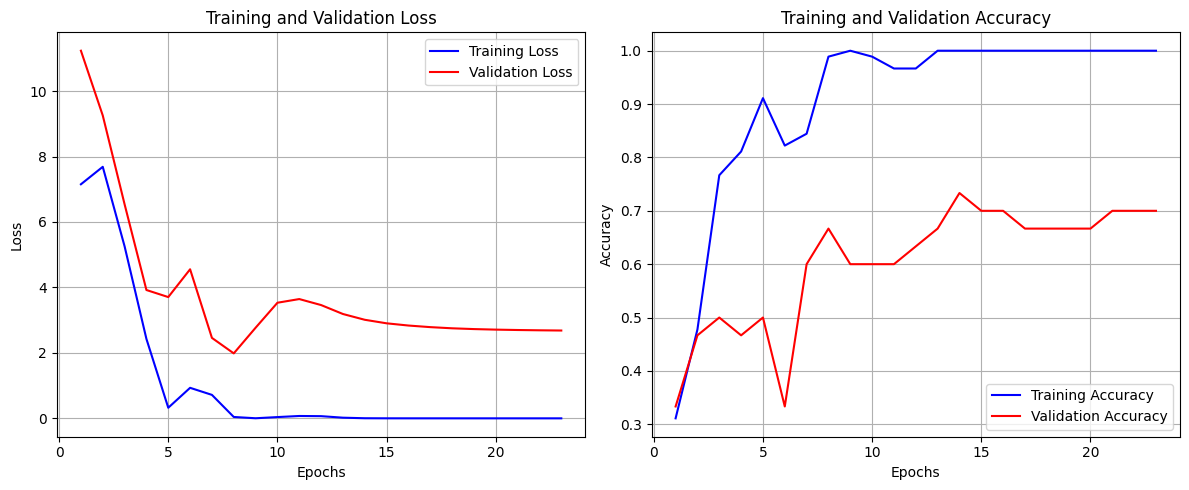

In [21]:
history_dict = history_vgg.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [22]:

predictions_vgg = model_vgg.predict(test_ds)
y_pred_vgg = np.argmax(predictions_vgg, axis=1)

# Classification Report
print("Classification Report for Task 2 (VGG16):")
print(classification_report(true_labels, y_pred_vgg, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
Classification Report for Task 2 (VGG16):
              precision    recall  f1-score   support

        acai       0.67      0.40      0.50         5
     cupuacu       0.50      0.40      0.44         5
    graviola       1.00      0.60      0.75         5
     guarana       1.00      1.00      1.00         5
     pupunha       0.67      0.80      0.73         5
      tucuma       0.44      0.80      0.57         5

    accuracy                           0.67        30
   macro avg       0.71      0.67      0.67        30
weighted avg       0.71      0.67      0.67        30

